In [85]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

## Load and combine the test and train data for processing

In [86]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

train['in_train'] = True
test['in_train'] = False

combined = pd.concat([train, test], axis=0, ignore_index=True)
combined.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,in_train
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,True
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,True
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,True
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,True
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,True


## Quick exploration and formatting of the data

In [87]:
print (combined.shape)
print (combined.dtypes)

(1309, 13)
Age            float64
Cabin           object
Embarked        object
Fare           float64
Name            object
Parch            int64
PassengerId      int64
Pclass           int64
Sex             object
SibSp            int64
Survived       float64
Ticket          object
in_train          bool
dtype: object


In [88]:
# Rename some of the columns to shorter or more desctiptive names
combined = combined.rename(columns={'Parch' : 'ParChld', 'PassengerId' : 'ID', 
                                    'Pclass' : 'Class'})

## Extract Title and Surname from the Name column
The Name column contains a Title and Surname which may provide more information serving as extra variables

In [89]:
import re

def getSurname(name):
    surname = re.search('(.*,)', name)
    return surname.group(0)[:-1] if surname else None

def getTitle(name):
    title = re.search('(, .*?\.)', name)
    return title.group(0)[2:-1] if title else None

combined['Surname'] = combined['Name'].apply(lambda x: getSurname(x))
combined['Title'] = combined['Name'].apply(lambda x: getTitle(x))

In [90]:
c = combined
c.groupby(['Sex', 'Title']).size()

Sex     Title       
female  Dona              1
        Dr                1
        Lady              1
        Miss            260
        Mlle              2
        Mme               1
        Mrs             197
        Ms                2
        the Countess      1
male    Capt              1
        Col               4
        Don               1
        Dr                7
        Jonkheer          1
        Major             2
        Master           61
        Mr              757
        Rev               8
        Sir               1
dtype: int64

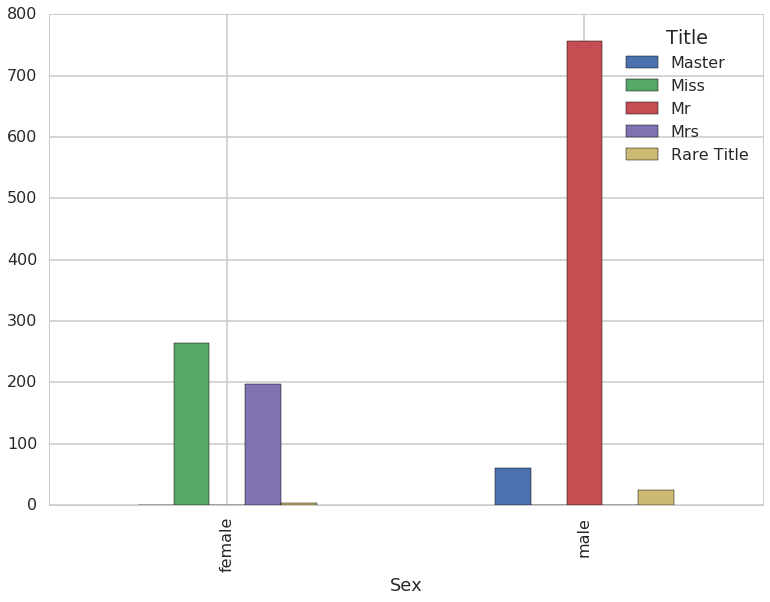

In [91]:
# Some binning of rare titles and googling to find synonomous titles
rare_title = ['Capt', 'Col', 'Don', 'Dona', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Rev', 'Sir', 
              'the Countess']
combined.loc[combined['Title'] == 'Mlle', 'Title'] = 'Miss'
combined.loc[combined['Title'] == 'Ms', 'Title'] = 'Miss'
combined.loc[combined['Title'] == "Mme", 'Title'] = "Mrs"
combined.loc[combined['Title'].isin(rare_title), 'Title'] = 'Rare Title'

combined.groupby(['Sex', 'Title']).size().unstack().fillna(0).plot(kind='bar')

## Missing value analysis
- Cabin looks to be missing too many values to be useful
- Emabraked and Fare are missing 1 and 2 values, should be easily replaced
- Age is a candidate for imputation

In [92]:
# Find the number of missing values for each column
combined.isnull().sum()

Age          263
Cabin       1014
Embarked       2
Fare           1
Name           0
ParChld        0
ID             0
Class          0
Sex            0
SibSp          0
Survived     418
Ticket         0
in_train       0
Surname        0
Title          0
dtype: int64

### Embarked missing values
Looking at the missing Embarked values it appears that Fare, Sex, and Class may be the relevant variables that can be used to set Embarked

In [93]:
combined[combined.Embarked.isnull()]

,Age,Cabin,Embarked,Fare,Name,ParChld,ID,Class,Sex,SibSp,Survived,Ticket,in_train,Surname,Title
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,True,Icard,Miss
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,True,Stone,Mrs


Based on the table below it appears that the missing Emabraked values are either C or S as there are a very small number of Class 1 passengers with Embarked value of Q.

In [94]:
combined.groupby(['Embarked', 'Class', 'Title']).agg({'Fare':[np.median, np.mean, 
                                                            np.count_nonzero]})

Fare                          
                              median        mean count_nonzero
Embarked Class Title                                          
C        1     Master      198.43750  198.437500           2.0
               Miss        106.42500  131.224868          31.0
               Mr           71.28330   94.761134          61.0
               Mrs          80.68540  111.187934          38.0
               Rare Title   39.60000   66.086111           9.0
         2     Master       37.00420   37.004200           1.0
               Miss         13.85830   24.575000           5.0
               Mr           15.04580   19.898169          16.0
               Mrs          28.89580   29.027783           6.0
         3     Master       15.24580   13.791138           8.0
               Miss         14.45830   14.886667          15.0
               Mr            7.22920    9.257806          62.0
               Mrs          14.45420   12.848181          16.0
Q        1     Miss         90.00000   90.000000           1.0
               Mrs          90.00000   90.000000           1.0
               Rare Title   90.00000   90.000000           1.0
         2     Miss         12.35000   12.350000           2.0
               Mr           11.52915   11.273950           4.0
               Rare Title   12.35000   12.350000           1.0
         3     Master       29.12500   29.125000           5.0
               Miss          7.75000    9.211796          53.0
               Mr            7.75000    9.234375          52.0
               Mrs          15.50000   20.041667           3.0
S        1     Master      120.00000  117.802767           3.0
               Miss        120.00000  127.378303          29.0
               Mr           35.25000   51.764542          92.0
               Mrs          58.50000   83.351868          38.0
               Rare Title   30.50000   53.615278           8.0
         2     Master       26.00000   26.425000          10.0
               Miss         21.00000   22.590909          44.0
               Mr           13.00000   19.735769         124.0
               Mrs          26.00000   23.411224          49.0
               Rare Title   13.00000   17.891667           9.0
         3     Master       24.45835   27.781509          32.0
               Miss          9.82500   17.500957          83.0
               Mr            7.92500   11.739560         330.0
               Mrs          16.10000   19.135596          46.0

In the table above Embarked C and Embarked S have very similar n, Fare median, and Fare mean for female, Class 1 passengers so there is no good reason to pick one over the other.

Because the summary statistics of Embarked C and Embarked S are to similar to make a judgement we need to look at the distributions.

/opt/conda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


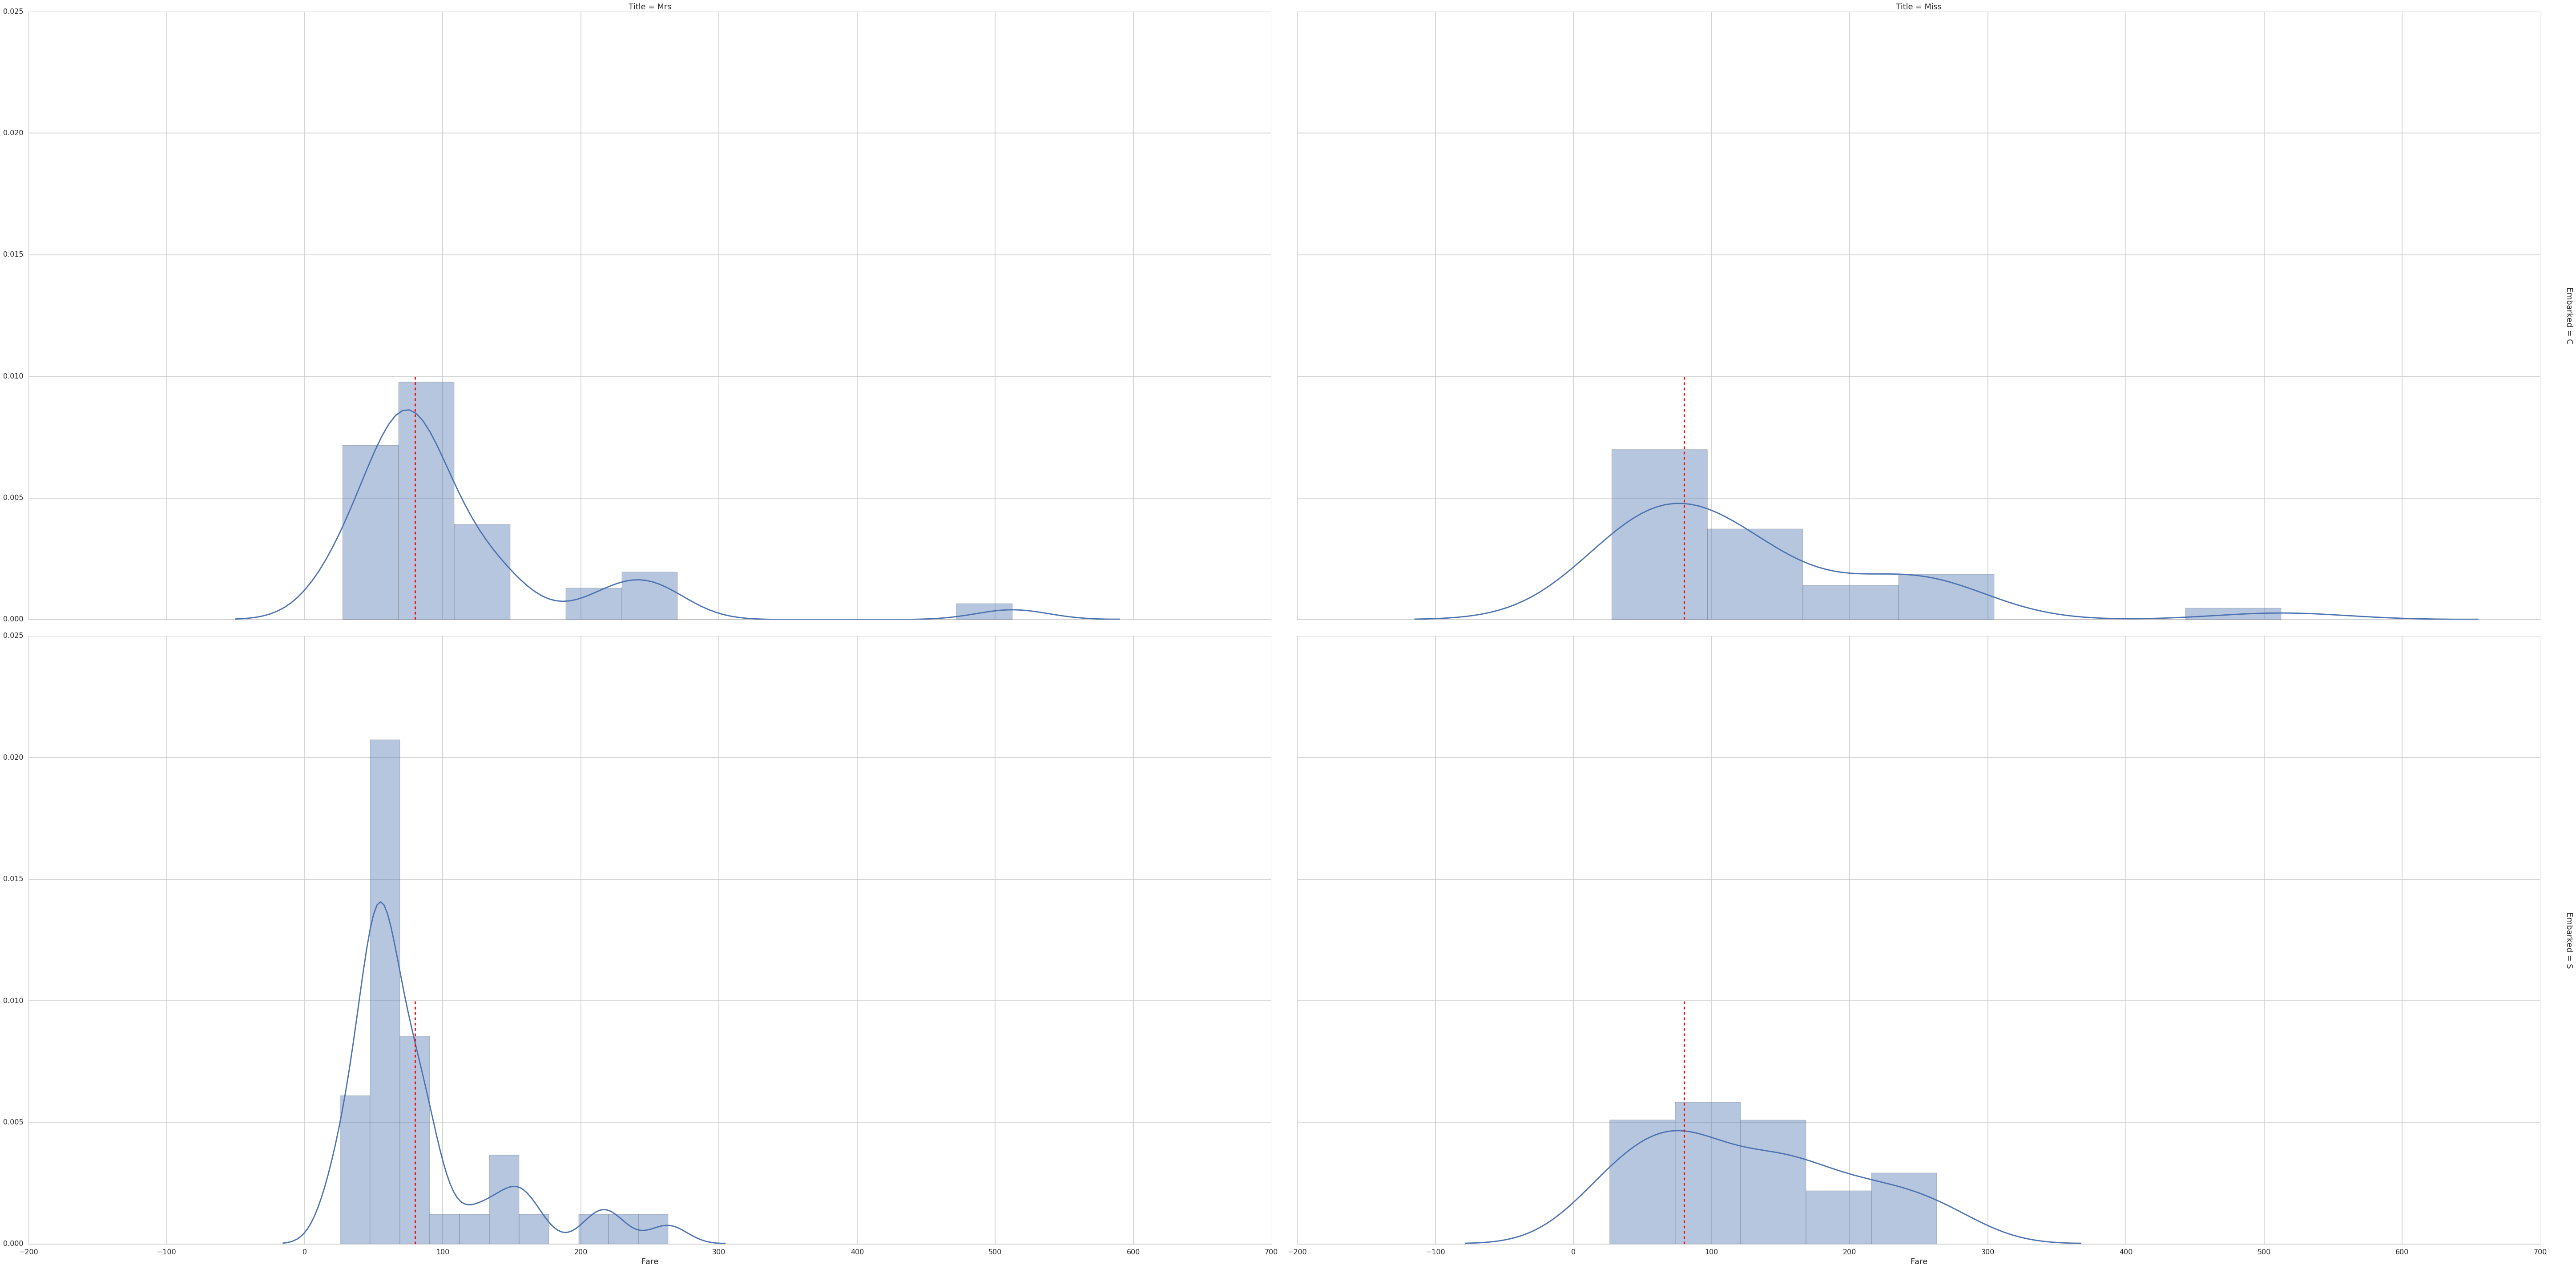

In [95]:
# Look at the distributions for titles Mrs & Miss, Class 1, passengers with Embarked 
# value C or S.
c = combined
c = c[((c.Title == 'Mrs') | (c.Title == 'Miss')) & 
      ((c.Embarked == 'C') | (c.Embarked == 'S')) & 
      (c.Class == 1)]
g = sns.FacetGrid(c, row='Embarked', col='Title', row_order=['C', 'S'], 
                  margin_titles=True, size=20, aspect=2)
g.map(sns.distplot, 'Fare')

# Add a line at Fare = 80 which is the value for both missing cases
for ax in g.axes.flat:
    ax.plot((80,80), (0, 0.01), color='r', ls='--')

It's very close but it looks like there is a little bit higher density at the Fare value 80 for Embarked value of C for both titles so we will replace our missing values with C.

In [96]:
# Replace the missing Embarked values with 'C'.
combined.loc[combined.Embarked.isnull(), 'Embarked'] = 'C'

### The missing Fare value
Similar to above we will look at Fare by Sex, Embarked, and Class

In [97]:
combined[combined.Fare.isnull()]

,Age,Cabin,Embarked,Fare,Name,ParChld,ID,Class,Sex,SibSp,Survived,Ticket,in_train,Surname,Title
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,False,Storey,Mr


/opt/conda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


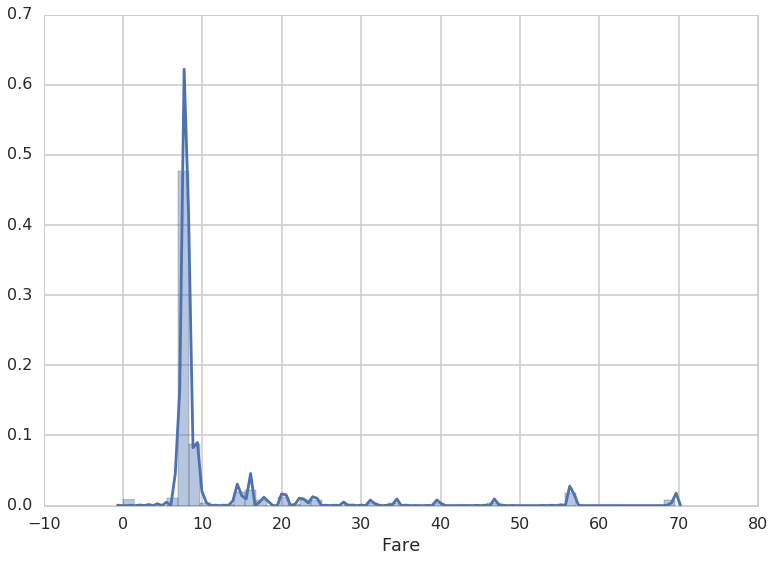

In [98]:
c = combined
c = c[(c.Title == 'Mr') & (c.Embarked == 'S') & (c.Class == 3)]
sns.distplot(c.Fare[c.Fare.notnull()])

The distribution above shows that the mean would skew a little high so the median should be used to replace the missing Fare value.

In [99]:
# Replace the missing Fare value with the median based on Sex, Embarked, and Class from the
# table above.
combined.loc[combined.Fare.isnull(), 'Fare'] = 7.925

### Missing Age values done two ways
1. Replace the missing age values with 0
2. Look for differentiation in age by ohter viariables

In [102]:
# Replace all missing ages with 0
combined_age1 = combined.copy()
combined_age1.Age = combined_age1.Age.fillna(0)

In [103]:
# Look for differentiation in age among other variables
combined.groupby(['Class','Embarked', 'Title']).agg({'Age':[np.median, np.mean]})

Age           
                          median       mean
Class Embarked Title                       
1     C        Master        9.5   9.500000
               Miss         32.0  32.774194
               Mr           39.0  40.490909
               Mrs          46.5  43.352941
               Rare Title   47.5  45.500000
      Q        Miss         33.0  33.000000
               Mrs          37.0  37.000000
               Rare Title   44.0  44.000000
      S        Master        4.0   5.306667
               Miss         26.0  27.206897
               Mr           42.0  42.136364
               Mrs          45.0  42.666667
               Rare Title   50.0  50.000000
2     C        Master        1.0   1.000000
               Miss         17.0  15.600000
               Mr           29.5  29.458333
               Mrs          23.5  22.500000
      Q        Miss         30.0  30.000000
               Mr           61.0  52.666667
               Rare Title   57.0  57.000000
      S        Master        2.0   2.933000
               Miss         20.0  21.265581
               Mr           30.0  32.131148
               Mrs          32.5  34.895833
               Rare Title   41.0  38.888889
3     C        Master        6.5   6.355000
               Miss          9.0   9.307692
               Mr           25.5  26.220588
               Mrs          24.0  27.666667
      Q        Master        7.0   6.200000
               Miss         22.0  23.157895
               Mr           30.0  33.156250
               Mrs          35.5  35.500000
      S        Master        5.5   6.032500
               Miss         20.0  17.284085
               Mr           26.0  28.295802
               Mrs          31.0  33.263158

In [106]:
# Create a dataframe of median ages by Class, Sex, and Title
mean_ages = combined.groupby(['Class', 'Sex', 'Title']).agg({'Age':np.mean}).unstack()
mean_ages.columns = mean_ages.columns.droplevel(0)
mean_ages = pd.melt(mean_ages.reset_index(), id_vars=['Class', 'Sex'], 
                      value_name='mean_age')

# Merge with the median_ages df on Class, Sex, and Title
c = combined.copy()
c = c.merge(mean_ages, how='left', on=['Class', 'Sex', 'Title'])

# Replace the missing Age values with the corresponding median age
combined_age2 = combined.copy()
missing_indexes = c[c.Age.isnull()].index
combined_age2.ix[missing_indexes, 'Age'] = c.ix[missing_indexes, 'mean_age']

In [141]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score

c = combined_age2
X_variables = ['Age', 'Fare', 'Class', 'Sex', 'Title']

# Lable Encode the factor variables: Embarked, Sex, Title
le_Embarked = LabelEncoder()
le_Sex = LabelEncoder()
le_Title = LabelEncoder()

c.Embarked = le_Embarked.fit_transform(c.Embarked)
c.Sex = le_Sex.fit_transform(c.Sex)
c.Title = le_Title.fit_transform(c.Title)

X_train = c.loc[c.in_train, X_variables]
y_train = c.loc[c.in_train, 'Survived']
X_test = c.loc[~c.in_train, X_variables]
y_test = c.loc[~c.in_train, 'Survived']

X_train.isnull().sum()
rf_clf = RandomForestClassifier(n_estimators=1000, oob_score=True)
rf_clf.fit(X_train, y_train)

pred_train = rf_clf.predict_proba(X_train)
fpr, tpr, _ = roc_curve(y_train, pred_train[:,1])
roc_auc = auc(fpr, tpr)
accuracy = accuracy_score(y_train, rf_clf.predict(X_train))
print ('Training ROC AUC: {:04.3f}'.format(roc_auc))
print ('Training Accuracy: {:04.3f}'.format(accuracy))
print ('OOB Score: {:04.3f}'.format(rf_clf.oob_score_))

Training ROC AUC: 0.997
Training Accuracy: 0.982
OOB Score: 0.820


In [142]:
# Variable importance
sorted(list(zip(X_variables, rf_clf.feature_importances_)), key=lambda x: x[1], reverse=True)

[('Fare', 0.32179160652932465),
 ('Age', 0.25893550604038612),
 ('Sex', 0.21511512644347058),
 ('Title', 0.1044998111464915),
 ('Class', 0.099657949840327026)]

In [125]:
# Create submission
pred_test = rf_clf.predict(X_test)
result = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': pred_test.astype(int)})
result.to_csv('result/result.csv', index=False, encoding='utf-8')